Notebook to demonstrate the IIR module capabilities

In [1]:
# Change the host name and configuration to suit your environment!
HOSTNAME = 'rp-f0bd75'
CONFIG = 'basic.filters'

In [2]:
import pyrpl
p = pyrpl.Pyrpl(config = CONFIG, hostname = HOSTNAME, gui = False)

QSocketNotifier: Can only be used with threads started with QThread
INFO:pyrpl:All your PyRPL settings will be saved to the config file
    /home/pas/pyrpl_user_dir/config/basic.filters.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe basic" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('basic')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname rp-f0bd75.

In [3]:
# create short cuts to the infinite impulse response and network analyser modules
iir = p.rp.iir
na = p.networkanalyzer

In a simple RC low pass filter there is a relationship between the time constant

$\tau = RC$

and the cut off frequency ($f_c$) of the low pass filter

$f_c = \displaystyle{1\over 2 \pi\tau}$

So either may be specified.  Here we choose to specify the desired cut off frequency of the
low pass filter that we are designing

In [4]:
TC = None
fc = 1.59235e6

In [5]:
import numpy as np
if TC is not None:
    fc = 1 / (2 * np.pi * TC)

The decimation factor of the infinite impulse response module is called "loops". Loops must be greater than 3 and less than 1024, thus defining the range of allowed cut off frequencies between 122KHz to 41.6MHz (3.8ns < $\tau$ <1.3us)

In [6]:
loops = round(125e6 / fc)

In [7]:
if 1023 < loops:
    loops = 1023
    print('frequency / time constant not possible - adjusted')
if loops < 3:
    loops = 3
    print('frequency / time constant not possible - adjusted')

In [8]:
fc = 125e6 / loops
TC = 1 / (2 * np.pi * fc)

The transfer function of a simple low pass filter is defined as

${v_o\over v_i} = {1\over 1 + j2\pi f RC}$

Defining the angular frequency as $\omega = 2\pi f$ we can simply this expression to

${v_o\over v_i} = {1\over 1 + j\omega\tau}$

Further define the angular frequency at the cut off frequency as $\omega_c = 2\pi f \tau$ then we can see from the complex expression that the phase of the output signal will be at $45^\circ$ to in input signal at the cut off frequency.

Notice also that if $j\omega = - {1\over\tau}$ then the transfer function becomes infinite.  Putting this another way there is a pole at $-\omega_c$,

A simple high pass filter has in addition got a zero at $\omega = 0$.

In [9]:
omegac = 1 / TC

In [10]:
rbw = 1000
points = 1001

In [11]:
zeros = []
poles = [ omegac * complex( -1, 0 )]

In [12]:
gain = 1e-9

In [13]:
iir.setup(gain = gain,
          zeros = zeros, poles = poles,
          loops = loops, 
          plot = False)

In [14]:
# useful diagnostic functions
print('IIR on: {}'.format(iir.on))
print('IIR bypassed: {}'.format(iir.bypass))
print('IIR loops: {} requested: {}'.format(iir.loops, loops))
print('IIR overflows: {}'.format(iir.overflow))
print('Coefficients (6 per biquad)\n{}'.format(iir.coefficients))

IIR on: True
IIR bypassed: False
IIR loops: 79 requested: 79
IIR overflows: no overflow
Coefficients (6 per biquad)
[[ 0.06246585  0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.         -0.        ]
 [ 0.          0.          0.          1.         -0.      

In [15]:
# check that the filter is ok before measuring the transfer function
print('IIR overflows before: {}'.format(iir.overflow))

IIR overflows before: no overflow


In [16]:
# now measure the tranfer function of iir filter using the network analysis module
stop_freq = 3e7
iir.input = na.iq
na.setup(start_freq = 1e4, stop_freq = stop_freq, rbw = rbw,
         points = points,
         average_per_point = 1,
         amplitude = 0.1,
         input = 'iir', output_direct = 'off',
         logscale=True)

In [17]:
tf = na.single()

In [18]:
# check that the filter is still ok after measuring the transfer function
print('IIR overflows after: {}'.format(iir.overflow))

IIR overflows after: no overflow


In [19]:
designdata = iir.transfer_function(na.frequencies)

In [20]:
# Now plot with design data
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

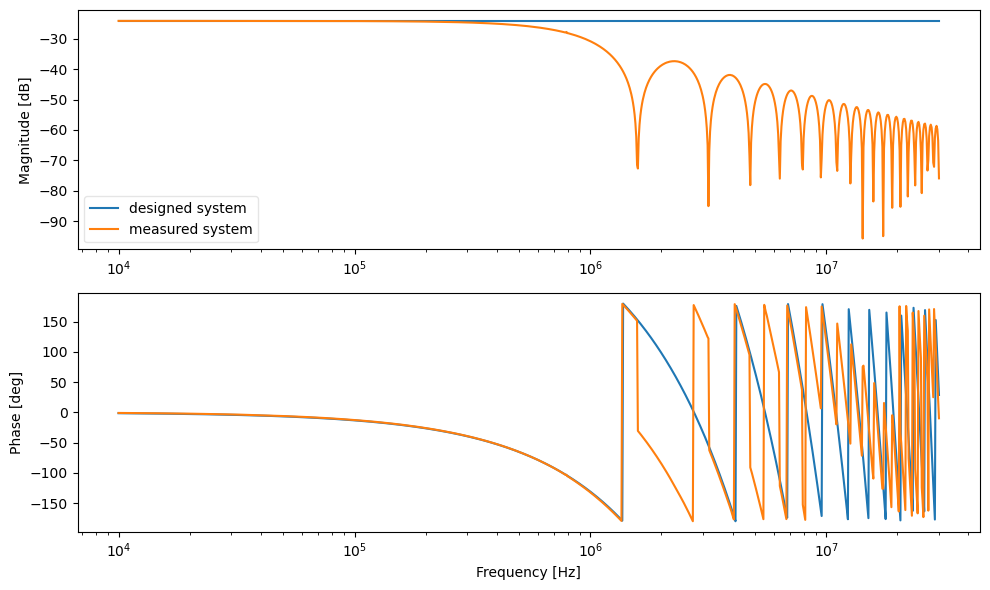

In [21]:
from pyrpl.hardware_modules.iir.iir_theory import bodeplot
bodeplot([(na.frequencies, designdata, 'designed system'),
          (na.frequencies, tf, 'measured system')], xlog=True)